# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [66]:
# 1.0)
#!pip3 install torch torchvision torchaudio torchviz

In [67]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [68]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [69]:
# 1.3)

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
from torchsummary import summary
#from torchviz import make_dot

In [70]:
# # 1.4)
# import google.colab
# from google.colab import files

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [72]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

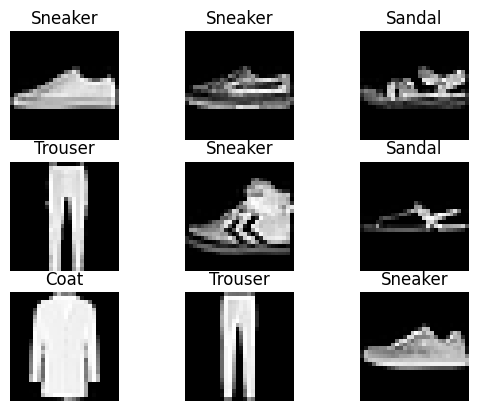

In [73]:
# 2.2)

labels_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [74]:
# 3.1)
class CustomDataset(Dataset):
    def __init__(self, dataset):
        """
        Inicializa el dataset personalizado.
        Args:
            dataset: Un dataset original de torchvision como FashionMNIST.
        """
        self.dataset = dataset

    def __len__(self):
        """
        Devuelve el tamaño del dataset.
        """
        return len(self.dataset)

    def __getitem__(self, i):
        """
        Devuelve el par (input, output), donde input y output son la misma imagen.
        Args:
            i: Índice de la imagen a obtener.
        Returns:
            tuple: (input, output) siendo ambos iguales.
        """
        image, _ = self.dataset[i]  # Ignoramos el label original
        return image, image

# Convertir los datasets originales a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

# Verificar el funcionamiento del CustomDataset
print(f"Tamaño del dataset de entrenamiento: {len(train_set)}")
print(f"Tamaño del dataset de validación: {len(valid_set)}")

# Obtener un ejemplo y verificar que input y output son iguales
example_input, example_output = train_set[0]
print(f"Shape del input: {example_input.shape}, Shape del output: {example_output.shape}")

Tamaño del dataset de entrenamiento: 60000
Tamaño del dataset de validación: 10000
Shape del input: torch.Size([1, 28, 28]), Shape del output: torch.Size([1, 28, 28])


## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoenconder convolucional* constituida por las siguientes capas:

1. Una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que deberá mapear $1$ canal de entradas de dimensiones $(28,28)$ a $16$ canales de de salida de dimensiones $(26,26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(26,26)$ a salidas de dimensiones $(13,13)$.

2. Una capa lineal constituida por:

* Una capa `Flatten` que mapea una entrada de $16$ canales de dimensiones $(13,13)$ a un vector de dimensión $16\times 13\times 13$.
* Una capa `Linear` que mapea un vector de dimensión $16\times 13\times 13$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

3. Una capa capa convolucional 2D transpuesta, constituida por:

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Para ello, utilice un kernel de dimensiones $(6,6)$ y un stride de dimensiones $(2,2)$, dejando el resto de los parámetros en sus valores por defecto, i.e. padding de $(1,1)$ y out_padding de $(0,0)$.

* Una capa `Sigmoid`.

**3)** Grafique, a modo de comparación, unas pocas imagenes a predecir vs las correspondientes imagenes predichas utilizando el modelo sin entrenar y dropout $p=0.2$.

In [75]:
# 4.1)
class ConvAutoencoder(nn.Module):
    def __init__(self, n, p=0.2):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(16 * 13 * 13, n),
            nn.ReLU(),
            nn.Dropout(p)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(n, 16 * 13 * 13),
            nn.ReLU(),
            nn.Unflatten(1, (16, 13, 13)),
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.decoder(x)
        return x


In [76]:
# Instanciar el modelo
n = 64  # Dimensión del vector latente
model = ConvAutoencoder(n, p=0.2).to(device)

# Mostrar la arquitectura del modelo
print(model)
#summary(model, (1,28,28))

# Prueba
image = torch.randn(1,1,28,28) # Batch, canal, size
output = model(image)
print(f'Input size: {image.shape}')
print(f'Output size: {output.shape}')

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=2704, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=2704, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(16, 13, 13))
    (3): ConvTranspose2d(16, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Input size: torch.Size([1, 1, 28, 28])
Output size: torch.Size([1, 1, 28, 28])


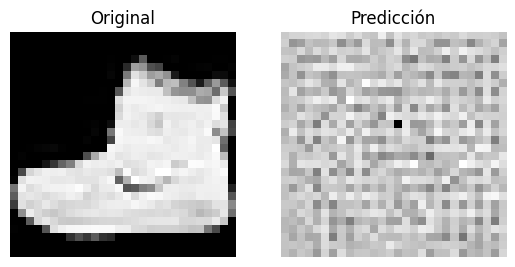

In [77]:
# Graficar imágenes originales y reconstruidas (sin entrenar)
figure, axes = plt.subplots(1, 2)
example_input = example_input.unsqueeze(0).to(device)  # Añadir batch dimension
with torch.no_grad():
    reconstructed = model(example_input).cpu()

axes[0].imshow(example_input.squeeze().cpu(), cmap="Greys_r")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(reconstructed.squeeze(), cmap="Greys_r")
axes[1].set_title("Predicción")
axes[1].axis("off")

plt.show()

Datos sin entrenar, la predicción es solo ruido

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [78]:
# 5.1)
def train_model(dataloader, model, loss_fn, optimizer, verbose=True):
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)

    sum_batch_avrg_loss = 0
    num_processed_samples = 0

    model.train()
    model = model.to(device)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        num_processed_samples += batch_size

        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss

        if batch % max(num_batches // 10, 1) == 0 and verbose:
            print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | '
                  f'Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    return avg_loss

# 5.2)
def valid_model(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            sum_batch_avrg_loss += loss.item()

    avg_loss = sum_batch_avrg_loss / num_batches
    print(f'Validation | Avg Loss: {avg_loss:.6f}')
    return avg_loss

In [79]:
# 5.3) Inicializar DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print('num_train_batches: ', num_train_batches)
print('num_valid_batches: ', num_valid_batches)

# 5.4) Función de pérdida (Error Cuadrático Medio)
loss_fn = nn.MSELoss()

# 5.5) Optimizador ADAM
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0, amsgrad=False)

# 5.6) Instanciar el modelo
#model = ConvAutoencoder(n=64, p=0.2)

# 5.7) Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_train_batches:  600
num_valid_batches:  100


In [80]:
# 5.6) Entrenamiento del modelo
num_epochs = 10
list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\\n' + '-' * 20)
    avg_train_loss_incorrecta = train_model(train_loader, model, loss_fn, optimizer)
    avg_train_loss = valid_model(train_loader, model, loss_fn)
    avg_valid_loss = valid_model(valid_loader, model, loss_fn)

    list_avg_train_loss_incorrecta.append(avg_train_loss_incorrecta)
    list_avg_train_loss.append(avg_train_loss)
    list_avg_valid_loss.append(avg_valid_loss)  

    print('avg_train_loss_incorrecta: ', avg_train_loss_incorrecta)
    print('avg_train_loss: ', avg_train_loss)
    print('avg_valid_loss: ', avg_valid_loss)

print('Entranamiento completo')

Epoch 1\n--------------------
Batch     0 | Loss: 1.379583 | Processed: 0.17%
Batch    60 | Loss: 0.658372 | Processed: 10.17%
Batch   120 | Loss: 0.662302 | Processed: 20.17%
Batch   180 | Loss: 0.683083 | Processed: 30.17%
Batch   240 | Loss: 0.694192 | Processed: 40.17%
Batch   300 | Loss: 0.707764 | Processed: 50.17%
Batch   360 | Loss: 0.676027 | Processed: 60.17%
Batch   420 | Loss: 0.649886 | Processed: 70.17%
Batch   480 | Loss: 0.613326 | Processed: 80.17%
Batch   540 | Loss: 0.628443 | Processed: 90.17%
Validation | Avg Loss: 0.616960
Validation | Avg Loss: 0.614394
avg_train_loss_incorrecta:  0.6763151569167772
avg_train_loss:  0.6169600280125936
avg_valid_loss:  0.6143936759233475
Epoch 2\n--------------------
Batch     0 | Loss: 0.628977 | Processed: 0.17%
Batch    60 | Loss: 0.612140 | Processed: 10.17%
Batch   120 | Loss: 0.612917 | Processed: 20.17%
Batch   180 | Loss: 0.604674 | Processed: 30.17%
Batch   240 | Loss: 0.622260 | Processed: 40.17%
Batch   300 | Loss: 0.58

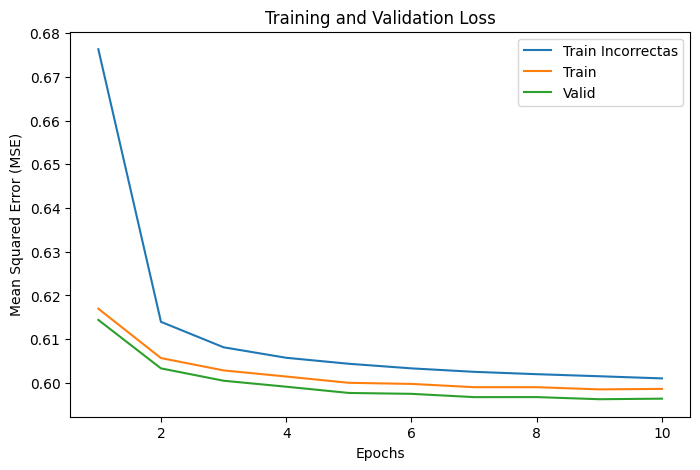

In [81]:
# 5.7) Graficar ECM en función de las épocas
plt.figure(figsize=(8,5))
plt.plot(list(range(1, len(list_avg_train_loss_incorrecta)+1)), list_avg_train_loss_incorrecta, label='Train Incorrectas')
plt.plot(list(range(1, len(list_avg_train_loss)+1)), list_avg_train_loss, label='Train')
plt.plot(list(range(1, len(list_avg_valid_loss)+1)), list_avg_valid_loss, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

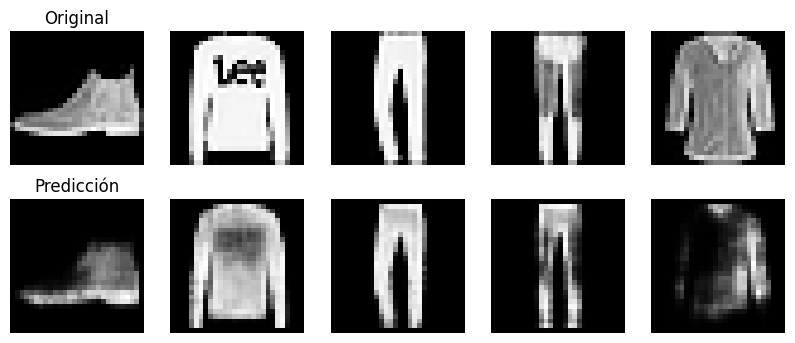

In [82]:
# 5.8) Graficar imágenes originales y reconstruidas
figure, axes = plt.subplots(2, 5, figsize=(10, 4))
model.eval()
with torch.no_grad():
    for i in range(5):
        img, _ = valid_set[i]
        img = img.unsqueeze(0).to(device)
        reconstructed = model(img).cpu()
        axes[0, i].imshow(img.squeeze().cpu(), cmap="Greys_r")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed.squeeze(), cmap="Greys_r")
        axes[1, i].axis("off")
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Predicción")
plt.show()